# InceptionV1 完成MNIST手写体识别



In [ ]:
#加载飞桨和相关类库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [ ]:
# 设置数据读取器，API自动读取MNIST数据训练集
train_dataset = paddle.vision.datasets.MNIST(mode='train')

Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


<Figure size 432x288 with 0 Axes>

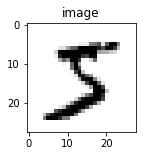

图像数据形状和对应数据为: (28, 28)
图像标签形状和对应数据为: (1,) [5]

打印第一个batch的第一个图像，对应标签数字为[5]


In [ ]:
train_data0 = np.array(train_dataset[0][0])
train_label_0 = np.array(train_dataset[0][1])

# 显示第一batch的第一个图像
import matplotlib.pyplot as plt
plt.figure("Image") # 图像窗口名称
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
plt.axis('on') # 关掉坐标轴为 off
plt.title('image') # 图像题目
plt.show()

print("图像数据形状和对应数据为:", train_data0.shape)
print("图像标签形状和对应数据为:", train_label_0.shape, train_label_0)
print("\n打印第一个batch的第一个图像，对应标签数字为{}".format(train_label_0))

In [ ]:
#train_data0
#paddle.to_tensor(train_data0)
train_dataset[0][0]

In [ ]:
"""testdata =[]
for i in range(16):
    testdata.append(train_dataset[i][0])    
#np.array(testdata)
#paddle.to_tensor(testdata)
norm_img(testdata)#  .astype('float32')"""

"testdata =[]\nfor i in range(16):\n    testdata.append(train_dataset[i][0])    \n#np.array(testdata)\n#paddle.to_tensor(testdata)\nnorm_img(testdata)#  .astype('float32')"

##  基本介绍
GoogLeNet是google推出的基于Inception模块的深度神经网络模型，在2014年的ImageNet竞赛中夺得了冠军，可以说Inception模块是这个网络的主要创新点，以下对该模块进行进一步叙述。

一般来说，提升网络性能最直接的办法就是增加网络深度和宽度，但一味地增加，会带来诸多问题：

1）参数太多，如果训练数据集有限，很容易产生过拟合；

2）网络越大、参数越多，计算复杂度越大，难以应用；

3）网络越深，容易出现梯度弥散问题（梯度越往后穿越容易消失），难以优化模型。

希望在增加网络深度和宽度的同时减少参数，为了减少参数，自然就想到将全连接变成稀疏连接。但是在实现上，全连接变成稀疏连接后实际计算量并不会有质的提升，因为大部分硬件是针对密集矩阵计算优化的，稀疏矩阵虽然数据量少，但是计算所消耗的时间却很难减少。

Inception就是把多个卷积或池化操作，放在一起组装成一个网络模块，设计神经网络时以模块为单位去组装整个网络结构。一个Inception模块中并列提供多种卷积核的操作，网络在训练的过程中通过调节参数自己去选择使用，同时，由于网络中都需要池化操作，所以此处也把池化层并列加入网络中。



### 本代码中使用的inception结构：

![](https://ai-studio-static-online.cdn.bcebos.com/2b297613493840f6923b7a49d836dbf25b78d22dbeea4192b73d302f29d6553a)



In [ ]:
# 导入需要的包
import paddle
import paddle.fluid as fluid
import numpy as np
#from paddle.fluid.dygraph import Conv2D, Pool2D, Linear, Dropout, BatchNorm

class InceptionA(fluid.dygraph.Layer):
    def __init__(self,  in_channels):
        super(InceptionA, self).__init__()
        self.branch3x3_1 = paddle.nn.Conv2D(in_channels, 16, kernel_size=1)
        self.branch3x3_2 = paddle.nn.Conv2D(16, 24, kernel_size=3, padding=1)
        self.branch3x3_3 = paddle.nn.Conv2D(24, 24, kernel_size=3, padding=1)

        self.branch5x5_1 = paddle.nn.Conv2D(in_channels, 16, kernel_size=1)
        self.branch5x5_2 = paddle.nn.Conv2D(16, 24, kernel_size=5, padding=2)

        self.branch1x1 = paddle.nn.Conv2D(in_channels, 16, kernel_size=1)
        self.branch_pool = paddle.nn.Conv2D(in_channels, 24, kernel_size=1)

    def forward(self, x):
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        branch3x3 = self.branch3x3_3(branch3x3)

        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)

        branch1x1 = self.branch1x1(x)

        branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
        branch_pool = self.branch_pool(branch_pool)

        outputs = [branch1x1, branch5x5, branch3x3, branch_pool]
        return fluid.layers.concat(outputs,axis=1)#24+24+16+24=88个通道

### 网络总框架
![](https://ai-studio-static-online.cdn.bcebos.com/a5977373fcf142fcb9ce1bf931c96f2aa2156deed4074c8c83c43efc6509b990)


In [ ]:

# 定义mnist数据识别网络结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        
        # 定义一层全连接层，输出维度是1
        self.conv1 = paddle.nn.Conv2D(1,10,kernel_size=5)
        self.conv2 = paddle.nn.Conv2D(88, 20, kernel_size=5)

        self.incep1=InceptionA(in_channels=10)
        self.incep2=InceptionA(in_channels=20)
        self.mp=paddle.nn.MaxPool2D(2)
        self.fc=paddle.nn.Linear(1408,10)

        
    # 定义网络结构的前向计算过程
    def forward(self, inputs):
        outputs = F.relu(self.mp(self.conv1(inputs)))
        outputs=self.incep1(outputs)
        outputs= F.relu(self.mp(self.conv2(outputs)))
        outputs=self.incep2(outputs)
        outputs=paddle.flatten(outputs,start_axis=1,stop_axis=3)
        outputs=self.fc(outputs)
        return outputs

In [104]:
# 声明网络结构
model = MNIST()

def train(model):
    # 启动训练模式
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    # 定义优化器，使用随机梯度下降SGD优化器，学习率设置为0.001
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())

In [107]:
# 图像归一化函数，将数据范围为[0, 255]的图像归一化到[0, 1]
def norm_img(img):
    # 验证传入数据格式是否正确，img的shape为[batch_size, 28, 28]
    assert len(img.shape) == 3
    batch_size, img_h, img_w = img.shape[0], img.shape[1], img.shape[2]
    # 归一化图像数据
    img = img/256
    # 将图像形式reshape为[batch_size, 784]
    #img = paddle.reshape(img, [batch_size, img_h*img_w])
    
    return img

In [111]:
import paddle
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.set_image_backend('cv2')

def train(model):
    model.train()
    # 加载训练集 batch_size 设为 16
    train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 5
    for epoch in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            images = np.reshape(norm_img(data[0]).astype('float32'),(16,1,28,28))
            #print(images.shape)#--------16*28*28
            images=paddle.to_tensor(images)
            labels = data[1].astype('float32')
            labels=paddle.to_tensor(labels,'int64')
            
            #前向计算的过程
            predicts = model(images)
            
            # 计算损失
            loss = F.cross_entropy(predicts, labels)
            
            avg_loss = paddle.mean(loss)
            
            #每训练了1000批次的数据，打印下当前Loss的情况
            if batch_id % 1000 == 0:
                print("epoch_id: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()
            
train(model)
paddle.save(model.state_dict(), './mnist.pdparams')

epoch_id: 0, batch_id: 0, loss is: [4.7997727]
epoch_id: 0, batch_id: 1000, loss is: [0.4053402]
epoch_id: 0, batch_id: 2000, loss is: [0.26519322]
epoch_id: 0, batch_id: 3000, loss is: [0.382811]
epoch_id: 1, batch_id: 0, loss is: [0.1918052]
epoch_id: 1, batch_id: 1000, loss is: [0.09023406]
epoch_id: 1, batch_id: 2000, loss is: [0.12096533]
epoch_id: 1, batch_id: 3000, loss is: [0.03642173]
epoch_id: 2, batch_id: 0, loss is: [0.11067546]
epoch_id: 2, batch_id: 1000, loss is: [0.01051531]
epoch_id: 2, batch_id: 2000, loss is: [0.24618137]
epoch_id: 2, batch_id: 3000, loss is: [0.02256395]
epoch_id: 3, batch_id: 0, loss is: [0.1867812]
epoch_id: 3, batch_id: 1000, loss is: [0.0022611]
epoch_id: 3, batch_id: 2000, loss is: [0.02227082]
epoch_id: 3, batch_id: 3000, loss is: [0.14495209]
epoch_id: 4, batch_id: 0, loss is: [0.00167645]
epoch_id: 4, batch_id: 1000, loss is: [0.00220581]
epoch_id: 4, batch_id: 2000, loss is: [0.08720379]
epoch_id: 4, batch_id: 3000, loss is: [0.03937264]


In [125]:
from paddle.metric import Accuracy
test_dataset = paddle.vision.datasets.MNIST(mode='test')
#随机抽取图片进行测试
def random_test(model,num=16):
    test_loader = paddle.io.DataLoader(test_dataset, places=paddle.CPUPlace(), batch_size=16,shuffle=True)
    for test_batch_id, test_data in enumerate(test_loader()):
        x_data = np.reshape(norm_img(test_data[0]).astype('float32'),(16,1,28,28))
        x_data=paddle.to_tensor(x_data)
        label = paddle.to_tensor(test_data[1],'int64')
    predicts = model(x_data)
    #返回正确率
    acc = paddle.metric.accuracy(predicts, label)
    print("The accuracy tested in randomly elected samples ：{}".format(acc.numpy()))

random_test(model,num=16)

The accuracy tested in randomly elected samples ：[0.9375]


##  代码问题检查1：模型输出全是NaN（已解决）

原因：此前定义的预处理函数得到数据是[-1,1]的区间，这样导致网络运行中某些带log的激活函数会出现NaN值，然后一直传到最后一层无法解决

解决方案：预处理到[0,1]区间

In [108]:
train_loader = paddle.io.DataLoader(paddle.vision.datasets.MNIST(mode='train'), 
                                        batch_size=16, 
                                        shuffle=True)
opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
i=0
for batch_id, data in enumerate(train_loader()):
    images = np.reshape(norm_img(data[0]).astype('float32'),(16,1,28,28))
    if i==0:
        a=images
        print(images)
        i+=1


[[[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 ...


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]]]


 [[[0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. ... 0. 0. 0.]
   ...
   [0. 0. 0. ... 0. 0. 0.]
   [0. 0. 0. 

In [110]:
a[0]#.shape

Tensor(shape=[1, 28, 28], dtype=float32, place=CPUPlace, stop_gradient=True,
       [[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.42968750, 0.53906250, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.42968750, 0.98828125, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.42968750, 0.98828125, 0.07031250, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [109]:
a=paddle.to_tensor(a)
#labels = data[1].astype('float32')
#labels=paddle.to_tensor(labels,'int64')

model(a)

Tensor(shape=[16, 10], dtype=float32, place=CPUPlace, stop_gradient=False,
       [[-0.39523733,  3.41638637, -2.70534849, -1.11444354,  0.91966367, -1.69769311, -1.20253968,  2.70562840, -1.89981616, -3.48688102],
        [ 0.52577829,  3.03583860,  1.55180597, -0.72082984, -1.79878044, -1.69482934, -1.20909858,  0.90282774, -1.43854737, -5.05113792],
        [ 1.32831538,  2.36602139,  0.51262408, -5.03250408,  0.00135395, -3.70850515, -4.11026287,  2.40073538, -4.60143089, -2.15255690],
        [ 1.24987125,  3.02824640,  2.32806635, -2.71725845, -0.19910458, -2.27741385, -1.64682758,  2.87785959, -3.22902203, -3.45862150],
        [-0.21479344,  3.73526430,  0.54694021, -2.19537902, -0.24378988, -2.91674089, -4.06910038,  2.70708418, -0.89984977, -5.77924395],
        [ 1.54220784,  5.30298328,  0.19954586, -3.38169408, -1.28786123, -3.83764124, -3.72705746,  6.18313599, -3.85934544, -5.79714584],
        [ 1.52260482,  3.28806782,  0.67446625, -1.10527766, -3.02747083,  1.44632399